In [44]:
import pandas as pd
import numpy as np
from datetime import datetime
from random import seed
import random
import seaborn as sns
%matplotlib inline

# 1. Load data from feather

In [45]:
# load feather data and convert to dataframe
# general data
general_data = pd.read_feather("/mnt/UKBiobank/main_reduced.ftr", columns=None, use_threads=True, storage_options=None)
general_data = pd.DataFrame(general_data)
# mri data
brain_data = pd.read_feather("/mnt/UKBiobank/fs_derivatives_reduced.ftr", columns=None, use_threads=True, storage_options=None)
brain_data = pd.DataFrame(brain_data)

# 2. Compute Age at MRI scan

<AxesSubplot:xlabel='Age', ylabel='Density'>

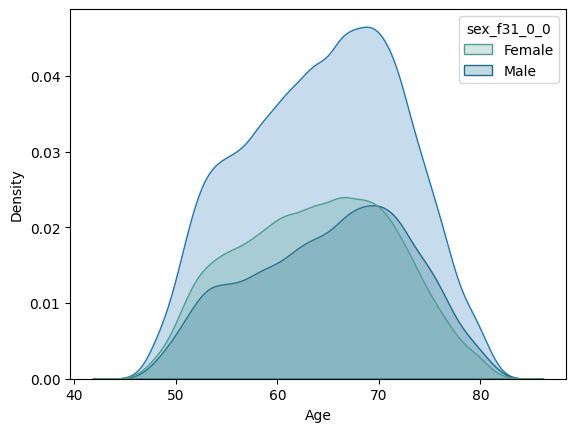

In [46]:
general_data['Age'] = pd.DatetimeIndex(pd.to_datetime(general_data.iloc[:,9912], format='%Y-%m-%d %H:%M:%S')).year - general_data.iloc[:,23]
brain_data["Age"] = general_data["Age"]
sns.kdeplot(data = general_data, x= 'Age', fill=True)
sns.kdeplot(data = general_data, x= 'Age', hue = 'sex_f31_0_0', fill=True, palette = "crest")

# 3. Split data based on completion of accelerometer assessment

In [47]:
# split data into people with completed physical activity accelerometer assessment (PA_yes) and without (PA_no)
comp = "Completed"
main_test = general_data[general_data["invitation_to_physical_activity_study_acceptance_f110005_0_0"] == comp]
main_train = general_data[general_data["invitation_to_physical_activity_study_acceptance_f110005_0_0"] != comp]
brain_test = brain_data[general_data["invitation_to_physical_activity_study_acceptance_f110005_0_0"] == comp]
brain_train = brain_data[general_data["invitation_to_physical_activity_study_acceptance_f110005_0_0"] != comp]

print(main_test.shape[0], "participants completed the accelerometer assessment and are assigned to the test set.", main_train.shape[0], "participants did not complete the accelerometer assessment are assigned the training set.")


19122 participants completed the accelerometer assessment and are assigned to the test set. 24045 participants did not complete the accelerometer assessment are are the training set.


# 4. Delete subjects with missing age

In [48]:
# delete rows that have a missing value for Age
index_age_train = brain_train[np.isnan(brain_train["Age"])].index
index_age_test = brain_test[np.isnan(brain_test["Age"])].index
brain_train = brain_train.drop(index_age_train)
brain_test = brain_test.drop(index_age_test)
main_test = main_test.drop(index_age_test)
main_train = main_train.drop(index_age_train)

print(len(index_age_train), "people were excluded from the training set and", len(index_age_test), "people were excluded from the test set based on missing age")

10 people were excluded from the training set and 6 people were excluded from the test set based on missing age


# 5. Randomly split test set into exploration (50%) and validation (50%) set

In [49]:
length = int(int(main_test.shape[0])-1)
half = int(int(main_test.shape[0])/2)
random_indices = random.sample(range(0, length), half)
main_test_validate = main_test.iloc[random_indices,:]
main_test = main_test.drop(main_test.iloc[random_indices].index)
brain_test_validate = brain_test.iloc[random_indices,:]
brain_test = brain_test.drop(brain_test.iloc[random_indices].index)

# check whether there is any overlap
overlap = np.asarray(main_test_validate.iloc[:,0]) == np.asarray(main_test.iloc[:,0])
print("Number of overlapping IDs", overlap.sum())

print("Size of exploration set:", main_test.shape[0])
print("Size of validation set:", main_test_validate.shape[0])

# store away validation data
main_test_validate.to_pickle("main_test_validate.pkl")
brain_test_validate.to_pickle("brain_test_validate.pkl")

# pickle exploration data for further analysis in next script
main_test.to_pickle("1_main_test.pkl")
main_train.to_pickle("1_main_train.pkl")
brain_test.to_pickle("1_brain_test.pkl")
brain_train.to_pickle("1_brain_train.pkl")

Number of overlapping IDs 0
Size of exploration set: 9558
Size of validation set: 9558
